# **MIE1624-Assignment 1-Junxi Xu**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn import linear_model

# **1. Data Cleaning**

##**(1). Dealing with Nan Values**

Target Variable (Q9) - Drop rows with missing target variables and outliers. (Remove all rows in Q9 with "I do not wish to disclose my approximate yearly compensation" which means salary is not disclosed. Also remove the rows witn "500,000+" because there are only very few respondents having over 500,000+ current yearly compensation and this value is diffucult to normalize (from 500,000 to infinity) during analysis. After removing these rows, we have clear insight on the yearly compensations for each respondent.

In [0]:
Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)
Salaries.dropna(subset=['Q9'],inplace=True)
Salaries = Salaries[Salaries['Q9']!= "I do not wish to disclose my approximate yearly compensation"]
Salaries = Salaries[Salaries['Q9']!= "500,000+"]

Remove columns with more than or equal to 70% missing values. If a column has more than 70% missing values, we can assume that this feature is invalid and useless for the prediction and for building the model.

In [0]:
col_names = Salaries.columns

In [0]:
cutoff=0.3
n = len(Salaries)
for col_name in col_names:
  cnt = Salaries[col_name].count()
  if (cnt / n) <= cutoff:
    Salaries.drop(col_name, axis=1, inplace=True)

Remove the text columns. Remove columns with the name "TEXT" or "OTHER", these columns are filled with values -1, which are useless. They do not give actual information. After removing these columns, we still have a large number of features. Stage 5 will deal with these features.

In [0]:
Salaries = Salaries[Salaries.columns.drop(list(Salaries.filter(regex='TEXT|OTHER')))] #Remove column with the name "Text" or "Other", these columns are filled with values -1, which are useless.

For those columns with less than 70% missing values, we can handle them by using different methods. For example, we can replace the Nan values with mean or mode, or completely remove the features with missing values (we remove the features with more than 70% missing values), or replace the Nan values with certain information (such as "Other"). Firstly, we look at which columns have Nan values by using the following code.

In [74]:
Salaries = Salaries.drop(Salaries.index[0]) #Remove first row, which is the question text.
a = Salaries.columns.tolist() ##show all the column names
b = Salaries.isnull().sum(axis=0).tolist() ##show how many Nan values in each column
pd.options.display.max_rows = None
pd.DataFrame({'Column_Name': a, 'Number_of_Nan':b})

,Column_Name,Number_of_Nan
0,Time from Start to Finish (seconds),0
1,Q1,0
2,Q2,0
3,Q3,0
4,Q4,0
5,Q5,129
6,Q6,0
7,Q7,0
8,Q8,76
9,Q9,0


Q8 - How many years of experience do you have in your current role? Some values are misisng because this question asks for years of experience. If the respondent is a student, he or she might not fill in this question. Therefore, we can look at Q7 and see how many missing values from Q8 are generated by students. 

In [75]:
S8 = Salaries[(Salaries['Q8'].isnull())]
len(S8[S8['Q7'] == 'I am a student'])/len(S8) #We can see that 76% of missing values in Q8 corresponds to respondents who are students.

0.7631578947368421

We can see that 76% of the missing values in Q8 are generated by students. Students usually have 0-1 year experience. So we replace the Nan values with 0-1

Q23 - Approximately what percent of your time at work or school is spent actively coding?
Q24 - How long have you been writing code to analyze data?
Q25 - For how many years have you used machine learning methods (at work or in school)?
Q43 - Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
Q46 - Approximately what percent of your data projects involve exploring model insights?
These questions ask for percentage of time or years in using machien learning and data analytics, and also percentage of projects relevent in data science. We can simply see that although the questions ask for information related to experience, the mising values are not generated by students. These missing values may be geneated just because the respondents do not want to answer, or simply ignore the questions. In this case, we can use the mode to replace the Nan values.

In [76]:
S24 = Salaries[(Salaries['Q24'].isnull())]
print(len(S24[S24['Q7'] == 'I am a student'])/len(S24))
S25 = Salaries[(Salaries['Q25'].isnull())]
print(len(S25[S25['Q7'] == 'I am a student'])/len(S25))

0.26425661914460286
0.2629462041226747


In [77]:
print(Salaries.Q23.mode()) #The most frequent value in Q23 is "50% to 74% of my time"
print(Salaries.Q24.mode()) #The most frequent value in Q24 is "1-2 years"
print(Salaries.Q25.mode()) #The most frequent value in Q25 is "< 1 year"
print(Salaries.Q43.mode()) #The most frequent value in Q43 is "0"
print(Salaries.Q46.mode()) #The most frequent value in Q46 is "10-20"

0    50% to 74% of my time
dtype: object
0    1-2 years
dtype: object
0    < 1 year
dtype: object
0    0
dtype: object
0    10-20
dtype: object


We get the mode for these questions and replace the missing values with the most frequent values. In other word, we treat these repondents as the most common respondents.

For Q5, Q12_MULTIPLE_CHOICE, Q17, Q18, Q20, Q22, Q37, the missing values may be generated because the respondents cannot find a category that matches his/her background. Therefore, we assign the Nan values with "Other".

For Q10, the missing values may be generated because the respondents do not know the answers. Therefore, we assign the Nan values with "I do not know".

For Q32, the missing values may be generated because the respondents cannot find a type of data from the list. ThereforeWe assign the Nan values with "Other Data".

For Q39_Part_1, Q39_Part_2, Q40, Q41_Part_1, Q41_Part_2, Q41_Part_3, the missing values may be generated because the respondents do not know the answers. Therefore, we assign the Nan values with "No opinion; I do not know".

For Q48,the missing values may be generated because the respondents do not know the answers. Therefore, we assign the Nan values with "I do not know; I have no opinion on the matter".

Now the above features do not have missing values so we might consider using these features but we still have to see the importance of them.

In [0]:
Salaries["Q5"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q8"].fillna("0-1", inplace = True)  #Assign Nan values with "0-1". Because most of the missing data from the column are generated by respondents who are students. Students usually have 0-1 year experience.
Salaries["Q10"].fillna("I do not know", inplace = True)  #Assign Nan values with "I do not know"
Salaries["Q12_MULTIPLE_CHOICE"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q17"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q18"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q20"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q22"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q23"].fillna("50% to 74% of my time", inplace = True)  #Assign Nan values with "50% to 74% of my time". This is the most frequent value in this column.
Salaries["Q24"].fillna("1-2 years", inplace = True)  #Assign Nan values with "1-2 years". This is the most frequent value in this column.
Salaries["Q25"].fillna("< 1 year", inplace = True)  #Assign Nan values with "< 1 year". This is the most frequent value in this column.
Salaries["Q32"].fillna("Other Data", inplace = True)  #Assign Nan values with "Other Data"
Salaries["Q37"].fillna("Other", inplace = True)  #Assign Nan values with "Other"
Salaries["Q39_Part_1"].fillna("No opinion; I do not know", inplace = True)  #Assign Nan values with "No opinion; I do not know"
Salaries["Q39_Part_2"].fillna("No opinion; I do not know", inplace = True)  #Assign Nan values with "No opinion; I do not know"
Salaries["Q40"].fillna("No opinion; I do not know", inplace = True)  #Assign Nan values with "No opinion; I do not know"
Salaries["Q41_Part_1"].fillna("No opinion; I do not know", inplace = True)  #Assign Nan values with "No opinion; I do not know"
Salaries["Q41_Part_2"].fillna("No opinion; I do not know", inplace = True)  #Assign Nan values with "No opinion; I do not know"
Salaries["Q41_Part_3"].fillna("No opinion; I do not know", inplace = True)  #Assign Nan values with "No opinion; I do not know"
Salaries["Q43"].fillna("0", inplace = True)  #Assign Nan values with "0"
Salaries["Q46"].fillna("10-20", inplace = True)  #Assign Nan values with "10-20"
Salaries["Q48"].fillna("I do not know; I have no opinion on the matter", inplace = True)  #Assign Nan values with "I do not know; I have no opinion on the matter"

## **(2).Convert categorical data into numerical data by encoding.**
Binary encoding, for all the features with only one selected choice, there is only one answer, or no answer (Nan values). For questions such as Q11, Q13, Q14, Q15, Q16, Q19, Q21, Q29, Q31, Q33, Q36, Q42, Q47, Q49, Q50, we can use binary encoding. We assign 0 to those missing values (the respondents do not answer) and assign 1 to the existing values (the respondents answer the questions). Because there are only "answer" or "not answer", and the answers are the same, so we use binary encoding.

In [0]:
Q11_cols = Salaries.loc[:,Salaries.columns.str.contains("Q11")]  #[col for col in Salaries.columns if 'Q11' in col]
for col in Q11_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q13_cols = Salaries.loc[:,Salaries.columns.str.contains("Q13")]  #[col for col in Salaries.columns if 'Q13' in col]
for col in Q13_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q14_cols = Salaries.loc[:,Salaries.columns.str.contains("Q14")]  #[col for col in Salaries.columns if 'Q14' in col]
for col in Q14_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q15_cols = Salaries.loc[:,Salaries.columns.str.contains("Q15")]  #[col for col in Salaries.columns if 'Q15' in col]
for col in Q15_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q16_cols = Salaries.loc[:,Salaries.columns.str.contains("Q16")]  #[col for col in Salaries.columns if 'Q16' in col]
for col in Q16_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q19_cols = Salaries.loc[:,Salaries.columns.str.contains("Q19")]  #[col for col in Salaries.columns if 'Q19' in col]
for col in Q19_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q21_cols = Salaries.loc[:,Salaries.columns.str.contains("Q21")]  #[col for col in Salaries.columns if 'Q21' in col]
for col in Q21_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q29_cols = Salaries.loc[:,Salaries.columns.str.contains("Q29")]  #[col for col in Salaries.columns if 'Q29' in col]
for col in Q29_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q31_cols = Salaries.loc[:,Salaries.columns.str.contains("Q31")]  #[col for col in Salaries.columns if 'Q31' in col]
for col in Q31_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q33_cols = Salaries.loc[:,Salaries.columns.str.contains("Q33")]  #[col for col in Salaries.columns if 'Q33' in col]
for col in Q33_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q36_cols = Salaries.loc[:,Salaries.columns.str.contains("Q36")]  #[col for col in Salaries.columns if 'Q36' in col]
for col in Q36_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q42_cols = Salaries.loc[:,Salaries.columns.str.contains("Q42")]  #[col for col in Salaries.columns if 'Q42' in col]
for col in Q42_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q47_cols = Salaries.loc[:,Salaries.columns.str.contains("Q47")]  #[col for col in Salaries.columns if 'Q47' in col]
for col in Q47_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q49_cols = Salaries.loc[:,Salaries.columns.str.contains("Q49")]  #[col for col in Salaries.columns if 'Q49' in col]
for col in Q49_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

Q50_cols = Salaries.loc[:,Salaries.columns.str.contains("Q50")]  #[col for col in Salaries.columns if 'Q50' in col]
for col in Q50_cols:
  Salaries.at[Salaries[col].notnull(),col] = 1  # not nan
  Salaries.at[Salaries[col].isnull(),col] = 0  # nan

In [80]:
Salaries.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11_Part_1,Q11_Part_4,Q12_MULTIPLE_CHOICE,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_9,Q14_Part_10,Q15_Part_2,Q15_Part_6,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q17,Q18,Q19_Part_1,Q19_Part_2,Q19_Part_3,Q20,Q21_Part_1,Q21_Part_2,Q21_Part_8,Q22,Q23,Q24,Q25,Q26,Q29_Part_10,Q31_Part_2,Q31_Part_6,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q32,Q33_Part_4,Q33_Part_7,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q36_Part_2,Q37,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q42_Part_2,Q43,Q46,Q47_Part_3,Q47_Part_8,Q48,Q49_Part_6,Q49_Part_7,Q50_Part_2
2,434,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000",No (we do not use ML methods),0,0,"Basic statistical software (Microsoft Excel, G...",0,0,0,0,1,0,1,0,0,1,Other,Python,0,0,0,Other,0,0,0,Other,1% to 25% of my time,I have never written code but I want to learn,I have never studied machine learning but plan...,Definitely not,0,0,0,0,0,0,Other Data,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Other,Slightly worse,No opinion; I do not know,Independent projects are equally important as ...,No opinion; I do not know,No opinion; I do not know,No opinion; I do not know,0,0,10-20,0,0,I do not know; I have no opinion on the matter,0,0,0
3,718,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000",I do not know,1,0,Local or hosted development environments (RStu...,0,0,0,0,1,0,1,0,1,0,Java,Python,0,0,0,Other,1,1,1,ggplot2,75% to 99% of my time,5-10 years,< 1 year,Definitely yes,0,1,1,0,1,1,Time Series Data,1,0,2,3,20,50,20,0,0,0,0,100,0,0,0,DataCamp,Slightly worse,Slightly better,Independent projects are equally important as ...,Very important,Very important,Very important,1,0-10,10-20,1,1,I am confident that I can explain the outputs ...,0,1,1
5,731,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000",I do not know,0,0,"Advanced statistical software (SPSS, SAS, etc.)",0,1,0,0,0,0,0,0,0,1,SQL,R,0,0,0,Other,0,0,0,Other,75% to 99% of my time,5-10 years,2-3 years,Maybe,0,1,0,0,0,0,Other Data,0,0,10,10,20,10,20,23,20,40,20,20,0,0,1,Coursera,Slightly better,Much better,Independent projects are slightly more importa...,Not at all important,Slightly important,Very important,0,20-30,20-30,0,0,I am confident that I can understand and expla...,0,0,1
7,959,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,"10-20,000",No (we do not use ML methods),0,0,"Basic statistical software (Microsoft Excel, G...",0,1,0,0,0,0,0,0,1,0,Other,R,0,0,0,Other,0,0,0,Other,25% to 49% of my time,< 1 year,< 1 year,Probably not,0,1,1,0,1,0,Numerical Data,0,0,0,30,50,0,0,20,50,20,30,0,0,0,0,Other,Slightly better,Neither better nor worse,Independent projects are much more important t...,Slightly important,Slightly important,Very important,0,0-10,0,0,0,I do not know; I have no opinion on the matter,0,0,0
8,1758,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"0-10,000","We recently started using ML methods (i.e., mo...",0,0,Local or hosted development environments (RStu...,1,0,1,1,0,0,0,1,0,0,Other,Python,1,0,1,Keras,1,1,1,Matplotlib,75% to 99% of my time,< 1 year,< 1 year,Probably not,1,0,1,1,1,0,Image Data,1,1,20,30,20,20,5,5,75,5,20,0,0,0,0,Udacity,Slightly better,Slightly better,Independent projects are slightly more importa...,Very important,Very important,Very important,1,0,10-20,0,0,"I view ML models as ""black boxes"" but I am con...",1,1,0


In order to better visualize the target variables, we normalize Q9 by taking the mean of current yearly compensation. 

In [81]:
import re
Q9list=[]
for num in Salaries["Q9"]:
  result= re.split('-|,',num)
  compensation = (int(result[0])*1000 + int(result[1])*1000)/2
  Q9list.append(compensation)
Q9list
Salaries["Q9"]= Q9list
Salaries.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11_Part_1,Q11_Part_4,Q12_MULTIPLE_CHOICE,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_9,Q14_Part_10,Q15_Part_2,Q15_Part_6,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q17,Q18,Q19_Part_1,Q19_Part_2,Q19_Part_3,Q20,Q21_Part_1,Q21_Part_2,Q21_Part_8,Q22,Q23,Q24,Q25,Q26,Q29_Part_10,Q31_Part_2,Q31_Part_6,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q32,Q33_Part_4,Q33_Part_7,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q36_Part_2,Q37,Q39_Part_1,Q39_Part_2,Q40,Q41_Part_1,Q41_Part_2,Q41_Part_3,Q42_Part_2,Q43,Q46,Q47_Part_3,Q47_Part_8,Q48,Q49_Part_6,Q49_Part_7,Q50_Part_2
2,434,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,15000.0,No (we do not use ML methods),0,0,"Basic statistical software (Microsoft Excel, G...",0,0,0,0,1,0,1,0,0,1,Other,Python,0,0,0,Other,0,0,0,Other,1% to 25% of my time,I have never written code but I want to learn,I have never studied machine learning but plan...,Definitely not,0,0,0,0,0,0,Other Data,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Other,Slightly worse,No opinion; I do not know,Independent projects are equally important as ...,No opinion; I do not know,No opinion; I do not know,No opinion; I do not know,0,0,10-20,0,0,I do not know; I have no opinion on the matter,0,0,0
3,718,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,5000.0,I do not know,1,0,Local or hosted development environments (RStu...,0,0,0,0,1,0,1,0,1,0,Java,Python,0,0,0,Other,1,1,1,ggplot2,75% to 99% of my time,5-10 years,< 1 year,Definitely yes,0,1,1,0,1,1,Time Series Data,1,0,2,3,20,50,20,0,0,0,0,100,0,0,0,DataCamp,Slightly worse,Slightly better,Independent projects are equally important as ...,Very important,Very important,Very important,1,0-10,10-20,1,1,I am confident that I can explain the outputs ...,0,1,1
5,731,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,5000.0,I do not know,0,0,"Advanced statistical software (SPSS, SAS, etc.)",0,1,0,0,0,0,0,0,0,1,SQL,R,0,0,0,Other,0,0,0,Other,75% to 99% of my time,5-10 years,2-3 years,Maybe,0,1,0,0,0,0,Other Data,0,0,10,10,20,10,20,23,20,40,20,20,0,0,1,Coursera,Slightly better,Much better,Independent projects are slightly more importa...,Not at all important,Slightly important,Very important,0,20-30,20-30,0,0,I am confident that I can understand and expla...,0,0,1
7,959,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,15000.0,No (we do not use ML methods),0,0,"Basic statistical software (Microsoft Excel, G...",0,1,0,0,0,0,0,0,1,0,Other,R,0,0,0,Other,0,0,0,Other,25% to 49% of my time,< 1 year,< 1 year,Probably not,0,1,1,0,1,0,Numerical Data,0,0,0,30,50,0,0,20,50,20,30,0,0,0,0,Other,Slightly better,Neither better nor worse,Independent projects are much more important t...,Slightly important,Slightly important,Very important,0,0-10,0,0,0,I do not know; I have no opinion on the matter,0,0,0
8,1758,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,5000.0,"We recently started using ML methods (i.e., mo...",0,0,Local or hosted development environments (RStu...,1,0,1,1,0,0,0,1,0,0,Other,Python,1,0,1,Keras,1,1,1,Matplotlib,75% to 99% of my time,< 1 year,< 1 year,Probably not,1,0,1,1,1,0,Image Data,1,1,20,30,20,20,5,5,75,5,20,0,0,0,0,Udacity,Slightly better,Slightly better,Independent projects are slightly more importa...,Very important,Very important,Very important,1,0,10-20,0,0,"I view ML models as ""black boxes"" but I am con...",1,1,0


Because scikit-learn can only take numerical values as input in a numpy array, we convert categorical variables into numerical values, using dummy variables. This encoding implies an ordered relationship between the values in the category. It is suitable for questions that have multiple answers. Each answer is created as a new column, if the feature belongs to this category, we assign 1, otherwise 0. Only one of the categorical feature columns can have of 1 because respondents only choose 1 answer each time. This encoding is good for features that have multiple categories, such as the below features.

In [82]:
dummy_Q1 = pd.get_dummies(Salaries['Q1'], prefix='Q1')
dummy_Q2 = pd.get_dummies(Salaries['Q2'], prefix='Q2')
dummy_Q3 = pd.get_dummies(Salaries['Q3'], prefix='Q3')
dummy_Q4 = pd.get_dummies(Salaries['Q4'], prefix='Q4')
dummy_Q5 = pd.get_dummies(Salaries['Q5'], prefix='Q5')
dummy_Q6 = pd.get_dummies(Salaries['Q6'], prefix='Q6')
dummy_Q7 = pd.get_dummies(Salaries['Q7'], prefix='Q7')
dummy_Q8 = pd.get_dummies(Salaries['Q8'], prefix='Q8')
dummy_Q10 = pd.get_dummies(Salaries['Q10'], prefix='Q10')
dummy_Q12_MULTIPLE_CHOICE = pd.get_dummies(Salaries['Q12_MULTIPLE_CHOICE'], prefix='Q12_MULTIPLE_CHOICE')
dummy_Q17 = pd.get_dummies(Salaries['Q17'], prefix='Q17')
dummy_Q18 = pd.get_dummies(Salaries['Q18'], prefix='Q18')
dummy_Q20 = pd.get_dummies(Salaries['Q20'], prefix='Q20')
dummy_Q22 = pd.get_dummies(Salaries['Q22'], prefix='Q22')
dummy_Q23 = pd.get_dummies(Salaries['Q23'], prefix='Q23')
dummy_Q24 = pd.get_dummies(Salaries['Q24'], prefix='Q24')
dummy_Q25 = pd.get_dummies(Salaries['Q25'], prefix='Q25')
dummy_Q26 = pd.get_dummies(Salaries['Q26'], prefix='Q26')
dummy_Q32 = pd.get_dummies(Salaries['Q32'], prefix='Q32')
dummy_Q37 = pd.get_dummies(Salaries['Q37'], prefix='Q37')
dummy_Q39_Part_1 = pd.get_dummies(Salaries['Q39_Part_1'], prefix='Q39_Part_1')
dummy_Q39_Part_2 = pd.get_dummies(Salaries['Q39_Part_2'], prefix='Q39_Part_2')
dummy_Q40 = pd.get_dummies(Salaries['Q40'], prefix='Q40')
dummy_Q41_Part_1 = pd.get_dummies(Salaries['Q41_Part_1'], prefix='Q41_Part_1')
dummy_Q41_Part_2 = pd.get_dummies(Salaries['Q41_Part_2'], prefix='Q41_Part_2')
dummy_Q41_Part_3 = pd.get_dummies(Salaries['Q41_Part_3'], prefix='Q41_Part_3')
dummy_Q43 = pd.get_dummies(Salaries['Q43'], prefix='Q43')
dummy_Q46 = pd.get_dummies(Salaries['Q46'], prefix='Q46')
dummy_Q48 = pd.get_dummies(Salaries['Q48'], prefix='Q48')

tempDF = pd.concat([Salaries["Time from Start to Finish (seconds)"],dummy_Q1,dummy_Q2,dummy_Q3,dummy_Q4,dummy_Q5,dummy_Q6,dummy_Q7,dummy_Q8,Salaries["Q9"],dummy_Q10,Salaries["Q11_Part_1"],Salaries["Q11_Part_4"],dummy_Q12_MULTIPLE_CHOICE,Salaries["Q13_Part_1"],Salaries["Q13_Part_2"],Salaries["Q13_Part_3"],Salaries["Q13_Part_9"],Salaries["Q14_Part_10"],Salaries["Q15_Part_2"],Salaries["Q15_Part_6"],Salaries["Q16_Part_1"],Salaries["Q16_Part_2"],Salaries["Q16_Part_3"],dummy_Q17,dummy_Q18,Salaries["Q19_Part_1"],Salaries["Q19_Part_2"],Salaries["Q19_Part_3"],dummy_Q20,Salaries["Q21_Part_1"],Salaries["Q21_Part_2"],Salaries["Q21_Part_8"],dummy_Q22,dummy_Q23,dummy_Q24,dummy_Q25,dummy_Q26,Salaries["Q29_Part_10"],Salaries["Q31_Part_2"],Salaries["Q31_Part_6"],Salaries["Q31_Part_8"],Salaries["Q31_Part_9"],Salaries["Q31_Part_10"],dummy_Q32,Salaries["Q33_Part_4"],Salaries["Q33_Part_7"],Salaries["Q36_Part_2"],dummy_Q37,dummy_Q39_Part_1,dummy_Q39_Part_2,dummy_Q40,dummy_Q41_Part_1,dummy_Q41_Part_2,dummy_Q41_Part_3,Salaries["Q42_Part_2"],dummy_Q43,dummy_Q46,Salaries["Q47_Part_3"],Salaries["Q47_Part_8"],dummy_Q48,Salaries["Q49_Part_6"],Salaries["Q49_Part_7"],Salaries["Q50_Part_2"]], axis=1)
#pd.set_option('display.max_columns', None)
DF = tempDF.drop(['Q1_Prefer not to say','Q1_Prefer to self-describe','Q3_Other','Q4_I prefer not to answer','Q5_Other','Q6_Other','Q7_Other','Q10_I do not know','Q12_MULTIPLE_CHOICE_Other','Q17_Other','Q18_Other','Q20_Other','Q22_Other','Q23_0% of my time','Q24_I have never written code and I do not want to learn','Q25_I have never studied machine learning and I do not plan to','Q32_Other Data','Q37_Other','Q39_Part_1_No opinion; I do not know','Q39_Part_2_No opinion; I do not know','Q40_No opinion; I do not know','Q41_Part_1_No opinion; I do not know','Q41_Part_2_No opinion; I do not know','Q41_Part_3_No opinion; I do not know','Q43_0','Q46_0','Q48_I do not know; I have no opinion on the matter'],axis=1)
DF.head()

,Time from Start to Finish (seconds),Q1_Female,Q1_Male,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,Q2_50-54,Q2_55-59,Q2_60-69,Q2_70-79,Q2_80+,Q3_Argentina,Q3_Australia,Q3_Austria,Q3_Bangladesh,Q3_Belarus,Q3_Belgium,Q3_Brazil,Q3_Canada,Q3_Chile,Q3_China,Q3_Colombia,Q3_Czech Republic,Q3_Denmark,Q3_Egypt,Q3_Finland,Q3_France,Q3_Germany,Q3_Greece,Q3_Hong Kong (S.A.R.),Q3_Hungary,Q3_I do not wish to disclose my location,Q3_India,Q3_Indonesia,"Q3_Iran, Islamic Republic of...",Q3_Ireland,...,Q40_Independent projects are slightly more important than academic achievements,Q41_Part_1_Not at all important,Q41_Part_1_Slightly important,Q41_Part_1_Very important,Q41_Part_2_Not at all important,Q41_Part_2_Slightly important,Q41_Part_2_Very important,Q41_Part_3_Not at all important,Q41_Part_3_Slightly important,Q41_Part_3_Very important,Q42_Part_2,Q43_0-10,Q43_10-20,Q43_20-30,Q43_30-40,Q43_40-50,Q43_50-60,Q43_60-70,Q43_70-80,Q43_80-90,Q43_90-100,Q46_0-10,Q46_10-20,Q46_20-30,Q46_30-40,Q46_40-50,Q46_50-60,Q46_60-70,Q46_70-80,Q46_80-90,Q46_90-100,Q47_Part_3,Q47_Part_8,Q48_I am confident that I can explain the outputs of most if not all ML models,Q48_I am confident that I can understand and explain the outputs of many but not all ML models,"Q48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","Q48_Yes, most ML models are ""black boxes""",Q49_Part_6,Q49_Part_7,Q50_Part_2
2,434,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,718,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1
5,731,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
7,959,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1758,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


NOTE: usually we can Drop one of each of the dummy variables because its value is implied by the other dummy variable columns. E.g. if class a = 0, and class b = 0, then it belongs to class c (assume there are only 3 classes). However, this can only be done if the features do not have Nan values. If the features have Nan values, when class a = 0 and class b = 0, it can belong to class c and Nan.

# **2.Exploratory data analysis**

## **(1).Visualize the order of feature importance**

After cleaning the data, we plot the correlation of Q9 (current yearly compensation) and other features. We can visualize the order of feature importance. It is clearly shown that Q9 of course has maximum value because we basically compare Q9 to itself. Then it is followed by Q3_United States of America, Q24_10-20 years, Q10_We have well established ML methods, etc. These features are more related to the respondent's yearly compensation.

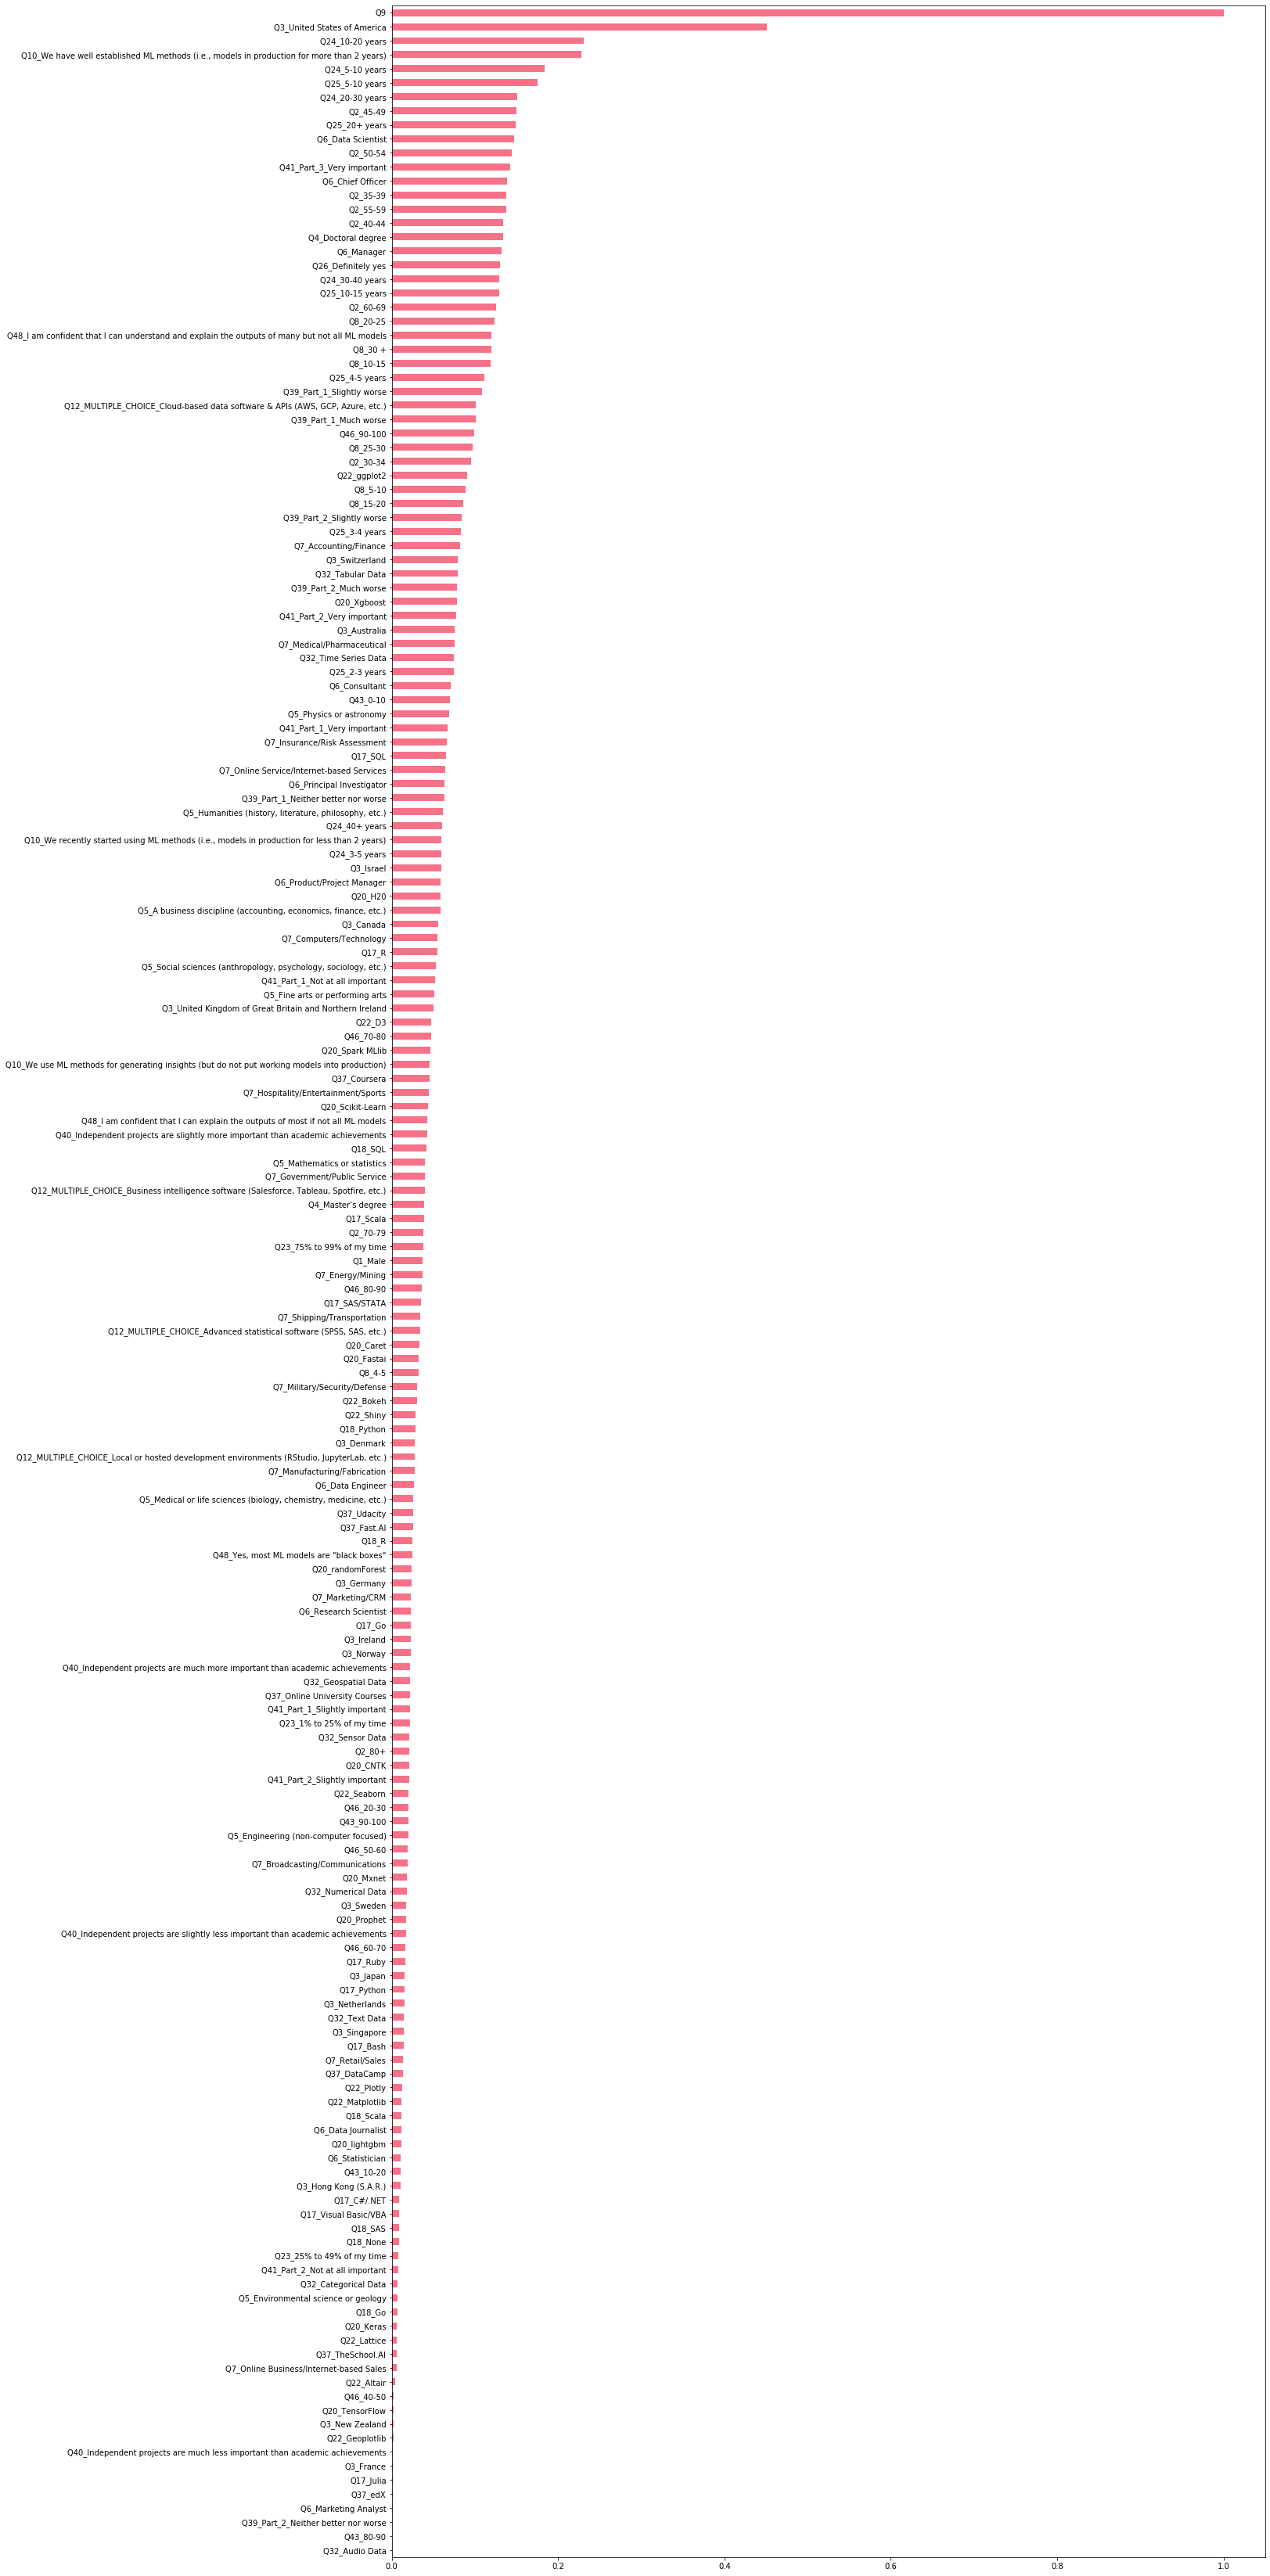

In [83]:
corr = DF.corr()
corr = corr.dropna(subset=["Q9"])
corr = corr[corr["Q9"]>0]
corr["Q9"].sort_values(ascending=True).plot(kind='barh',figsize=(20,60))

## **(2).Present 3 graphical figures that represent trends in the data.**

(a).Overall yearly compensation distribution

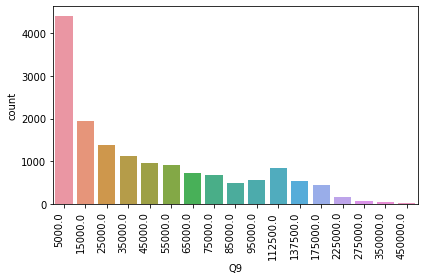

In [84]:
ax = sns.countplot(x="Q9",data=Salaries)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

(b). Gender and yearly compensation

We can see that most of the respondents are male. Also by looking at the overall yearly compensation by gender, we clearly see that male have higher compensation. We may assume that gender does have effect on the yearly compensation and male usually have more compensation than female.

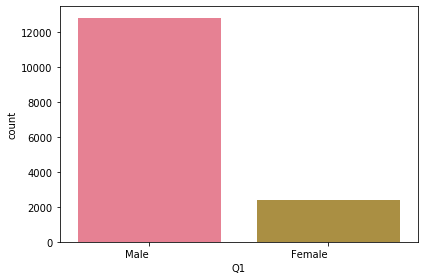

In [85]:
ax = sns.countplot(x="Q1",data=Salaries,order=["Male","Female"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.tight_layout()
plt.show()

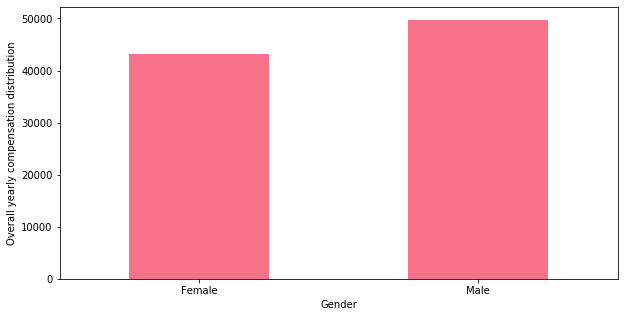

In [86]:
px = Salaries[Salaries.Q1.isin(['Female','Male'])].groupby(['Q1'])['Q9'].mean().sort_values().plot(kind="bar", figsize=(10,5))
px.set(xlabel='Gender', ylabel='Overall yearly compensation distribution')
px.set_xticklabels(px.get_xticklabels(), rotation=0)
plt.show()

(c). Country and yearly compensation

We can see that most of the respondents are from USA and India. Also by looking at the overall yearly compensation by country, we clearly see that many Europe and North America countries have higher compensation. These are mostly developed countries. We may assume that developed countries usually have more compensation than developing countries.

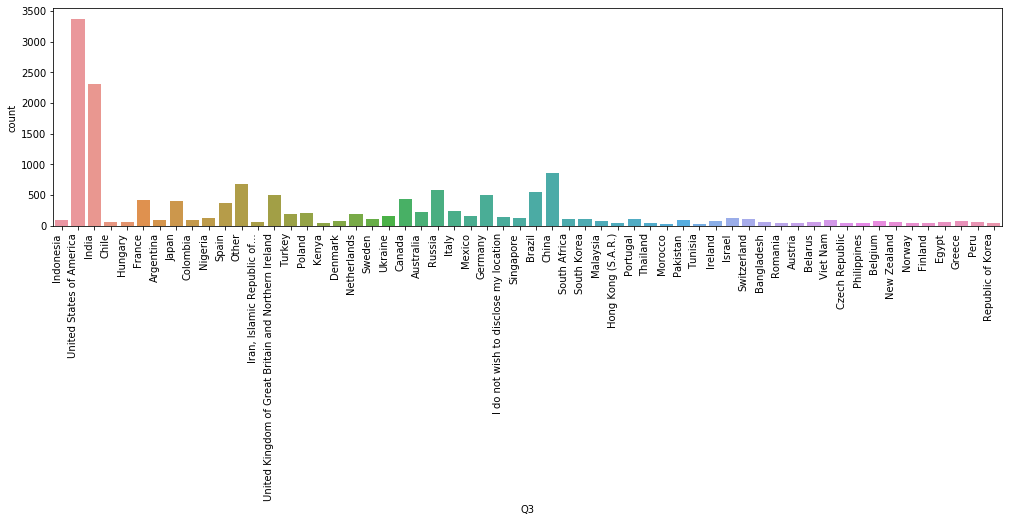

In [87]:
plt.figure(figsize=(17,4))
ax = sns.countplot(x="Q3",data=Salaries)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

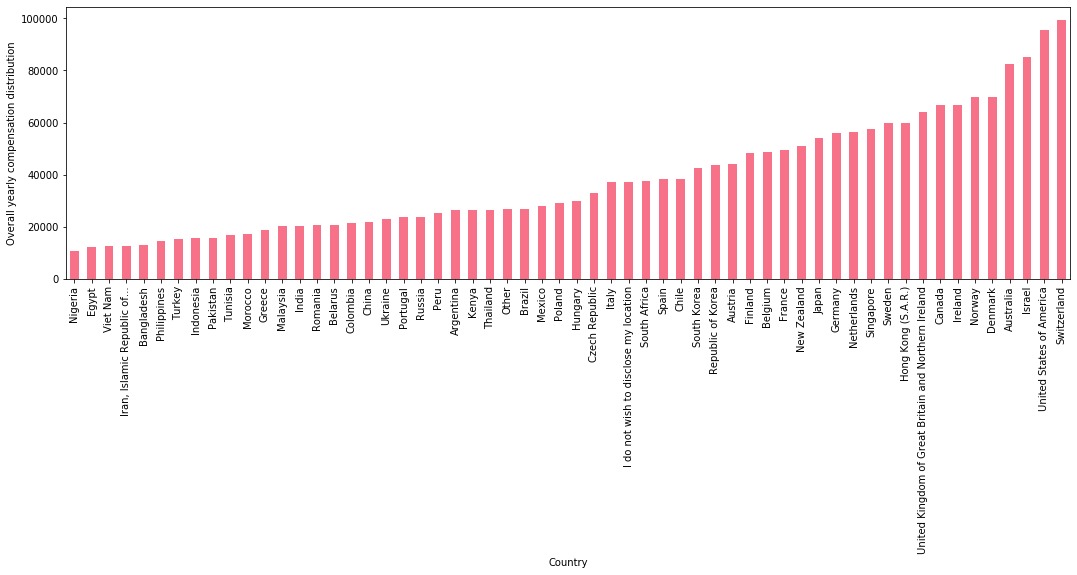

In [88]:
px = Salaries.groupby(['Q3'])['Q9'].mean().sort_values().plot(kind="bar", figsize=(18,5))
px.set(xlabel='Country', ylabel='Overall yearly compensation distribution')
px.set_xticklabels(px.get_xticklabels(), rotation=90)
plt.show()

(d). Education level and yearly compensation

We can see that lots of the respondents have a Master's degree. Also by looking at the overall yearly compensation by education level, we clearly see that many respondents with higher ecudation level have higher compensation. This makes sense as well.

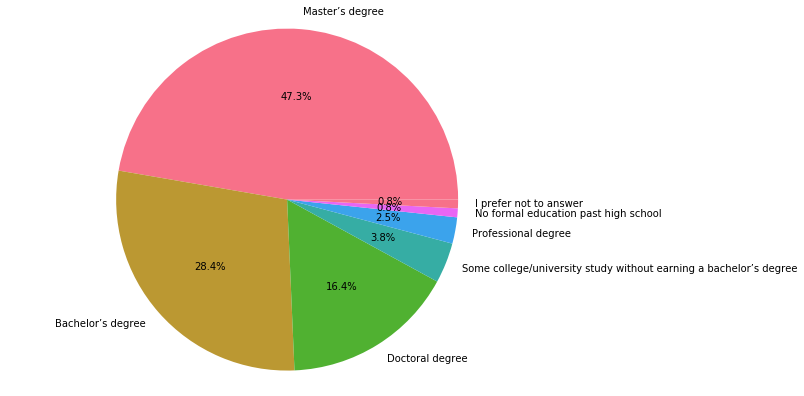

In [89]:
sns.set_palette('husl')
px = Salaries['Q4'].value_counts(normalize=True).plot(kind='pie', autopct='%.1f%%', figsize=(10,7))
px.axis('equal')
px.get_yaxis().set_visible(False)

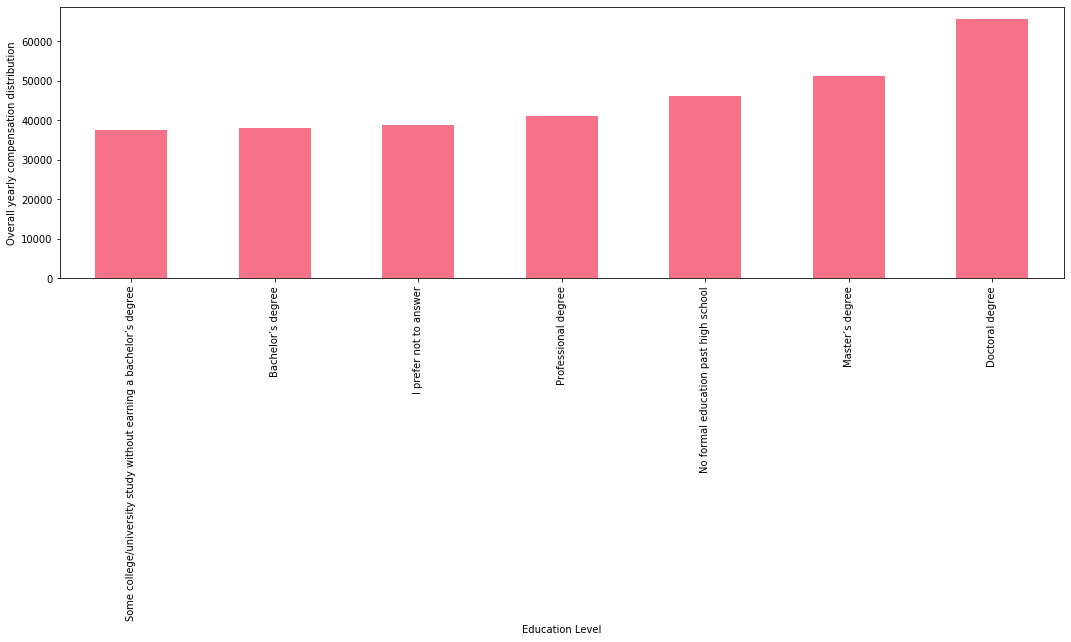

In [90]:
px = Salaries.groupby(['Q4'])['Q9'].mean().sort_values().plot(kind="bar", figsize=(18,5))
px.set(xlabel='Education Level', ylabel='Overall yearly compensation distribution')
px.set_xticklabels(px.get_xticklabels(), rotation=90)
plt.show()

# **3.Feature Selection**

Features are important to predictive models and influence results. The result depends on features chosen and also the model and the data itself. However, choosing the right features is very important which brings better results.
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. If feature engineering is done correctly, it increases the predictive power of machine learning algorithms by creating features from raw data that help facilitate the machine learning process.

From the above section, we can see that we still have many features. We should do feature selection to filter out the unimportant features. Here we use Lasso Regularization for feature selection. Regularized regression basically adds a penalty to different parameters of the model and avoid overfitting (increase the penalisation will increase the number of features removed, we do not want the penalty too high, which will remove important features, or too low, which will keep the unimportant features). Lasso regression is useful to shrink some coefficients to 0 by imposing a constraint on the parameters then the feature can be removed.

In [0]:
Salaries_Train,Salaries_Test = train_test_split(DF,test_size=0.33, random_state=13)
Salaries_Y_Train = Salaries_Train['Q9']
Salaries_X_Train = Salaries_Train.drop(['Q9'], axis=1)
Salaries_Y_Test = Salaries_Test['Q9']
Salaries_X_Test = Salaries_Test.drop(['Q9'], axis=1)

In [92]:
reg = linear_model.Lasso(alpha = 0.5,max_iter=10000) # optimal parameters are entered
reg.fit(Salaries_X_Train, Salaries_Y_Train)
reg.score(Salaries_X_Train, Salaries_Y_Train)

0.5526564516786191

In [0]:
from sklearn.metrics import make_scorer, r2_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
reg_gridsearch = linear_model.Lasso(random_state=42)
#Parameters to test
parameters = {'alpha':[0.5,1,3], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

# Run the grid search
grid_obj_lm = GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_lm)
grid_obj_lm = grid_obj_lm.fit(Salaries_X_Train, Salaries_Y_Train)

reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination

In [94]:
reg_gridsearch.fit(Salaries_X_Train, Salaries_Y_Train)
reg_gridsearch.score(Salaries_X_Train, Salaries_Y_Train)

0.5448070319668048

In [95]:
predictions_lasso=reg_gridsearch.predict(Salaries_X_Test)
mean_absolute_error(Salaries_Y_Test,predictions_lasso)

23167.76612825103

In [0]:
def run_kfold(model):
    
    X = Salaries_X_Train
    Y = Salaries_Y_Train
    
    kf = KFold(n_splits=10) # Provides train/test indices to split data in train/test sets.
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

In [97]:
run_kfold (reg)

Fold 1 accuracy: 0.5527608144513727
Fold 2 accuracy: 0.5478196827272116
Fold 3 accuracy: 0.47994615441330857
Fold 4 accuracy: 0.5733748134167043
Fold 5 accuracy: 0.41962819120438866
Fold 6 accuracy: 0.5129015000632111
Fold 7 accuracy: 0.5033820376578028
Fold 8 accuracy: 0.5436953834052956
Fold 9 accuracy: 0.5418852022524874
Fold 10 accuracy: 0.4848657551225226
Mean r2: 0.5160259534714305
Standard Deviation: 0.04338012254031444


We take the top 100 most important features to form a list. Then we further select the top 50 features based on the regression coefficient.

In [0]:
feature_list=sorted(list(zip(reg.coef_, Salaries_X_Train)),reverse=True)[0:100]

In [99]:
features=[]
for feature_comb in feature_list:
  feature = feature_comb[1]
  features.append(feature)
features = features[0:51]
features

['Q3_United States of America',
 'Q3_Switzerland',
 'Q3_Israel',
 'Q3_Australia',
 'Q3_Denmark',
 'Q6_Chief Officer',
 'Q3_Canada',
 'Q3_Singapore',
 'Q3_Norway',
 'Q8_30 +',
 'Q25_20+ years',
 'Q3_Hong Kong (S.A.R.)',
 'Q3_Ireland',
 'Q3_United Kingdom of Great Britain and Northern Ireland',
 'Q37_TheSchool.AI',
 'Q3_New Zealand',
 'Q3_Germany',
 'Q24_30-40 years',
 'Q3_Netherlands',
 'Q3_Austria',
 'Q25_5-10 years',
 'Q25_10-15 years',
 'Q20_Prophet',
 'Q3_Japan',
 'Q8_20-25',
 'Q25_4-5 years',
 'Q24_10-20 years',
 'Q3_Sweden',
 'Q3_South Africa',
 'Q3_France',
 'Q6_Manager',
 'Q18_Go',
 'Q2_55-59',
 'Q20_H20',
 'Q25_2-3 years',
 'Q10_We have well established ML methods (i.e., models in production for more than 2 years)',
 'Q3_Belgium',
 'Q3_South Korea',
 'Q3_Finland',
 'Q25_I have never studied machine learning but plan to learn in the future',
 'Q25_3-4 years',
 'Q2_45-49',
 'Q25_< 1 year',
 'Q3_China',
 'Q3_I do not wish to disclose my location',
 'Q8_25-30',
 'Q24_5-10 years',
 

We generated a new dataframe by using the above 50 features (the top 50 most important features, found by the Lasso regression model)

In [100]:
NewDF = DF[[feature for feature in features]]
NewDF["Q9"]=DF["Q9"].values
NewDF.head()

,Q3_United States of America,Q3_Switzerland,Q3_Israel,Q3_Australia,Q3_Denmark,Q6_Chief Officer,Q3_Canada,Q3_Singapore,Q3_Norway,Q8_30 +,Q25_20+ years,Q3_Hong Kong (S.A.R.),Q3_Ireland,Q3_United Kingdom of Great Britain and Northern Ireland,Q37_TheSchool.AI,Q3_New Zealand,Q3_Germany,Q24_30-40 years,Q3_Netherlands,Q3_Austria,Q25_5-10 years,Q25_10-15 years,Q20_Prophet,Q3_Japan,Q8_20-25,Q25_4-5 years,Q24_10-20 years,Q3_Sweden,Q3_South Africa,Q3_France,Q6_Manager,Q18_Go,Q2_55-59,Q20_H20,Q25_2-3 years,"Q10_We have well established ML methods (i.e., models in production for more than 2 years)",Q3_Belgium,Q3_South Korea,Q3_Finland,Q25_I have never studied machine learning but plan to learn in the future,Q25_3-4 years,Q2_45-49,Q25_< 1 year,Q3_China,Q3_I do not wish to disclose my location,Q8_25-30,Q24_5-10 years,Q7_Accounting/Finance,Q18_None,Q25_1-2 years,Q20_Caffe,Q9
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,15000.0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,5000.0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5000.0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,15000.0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5000.0


# **4. Model implementation**

## **(1).Apply logistic regression algorithm.**

Firstly we split the data from above section into training data and testing data. Then we target the training data and split it into validation set and training set. We use logistic regression model to the training set then test in the validation set, using 10-fold cross-validation.

In [0]:
trainDF, testDF = train_test_split(NewDF, test_size=0.3) #Separate new dataframe into trainDF and testDF

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

In [0]:
X = trainDF.drop(['Q9'],axis=1)
y = trainDF['Q9']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [0]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [106]:
model = LogisticRegression()    
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## **(2).Validate model: Get accuracy of model on testing set**

We can now use the model that we created to make predictions on the testing set we created earlier.

In [107]:
predictions = model.predict(X_test)
    
TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 70.79% on the testing set


## **(3).Evaluation: Cross Validation**

In [108]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.718%
Fold 2: Accuracy: 0.702%
Fold 3: Accuracy: 0.76%
Fold 4: Accuracy: 0.725%
Fold 5: Accuracy: 0.697%
Fold 6: Accuracy: 0.702%
Fold 7: Accuracy: 0.709%
Fold 8: Accuracy: 0.704%
Fold 9: Accuracy: 0.697%
Fold 10: Accuracy: 0.668%
Average Score: 70.828%(2.241%)


We can see the model average accuracy and standard deviation above. The accuracies across the folds are close. They are around 70%.

The default hyperparameters are C=1.0 and solver='warn'. We try to tune one hyperparameter. Let's select C=0.001 and solver is still "warn". Based on the 10-fold cross validation, we see that the accuracy drops a little bit. Therefore the above model performs better. This is because λ = 1/C. If C is smaller, λ increases. When λ increases, the optimization Gradient Descent will have to further reduce the values of weight to reduce the value of product. Thus, greater is the value of λ, smaller will be the weights and smaller will be the importance of the feature leading to greater variance.

In [109]:
model = LogisticRegression(C=0.001, solver='warn')
accuracy = np.zeros(10)
np_idx = 0
for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.713%
Fold 2: Accuracy: 0.704%
Fold 3: Accuracy: 0.737%
Fold 4: Accuracy: 0.719%
Fold 5: Accuracy: 0.701%
Fold 6: Accuracy: 0.7%
Fold 7: Accuracy: 0.708%
Fold 8: Accuracy: 0.683%
Fold 9: Accuracy: 0.694%
Fold 10: Accuracy: 0.675%
Average Score: 70.338%(1.676%)


# **5.Hyperparameter tuning**

The optimal model is given by the hyperparameter C and solver shown below. The best score and variance are also shown below. We use accuracy, which is the number of correct predictions made by the model over all kinds predictions made. It is easily suited for binary as well as a multiclass classification problem. Also accuracy is a good measure when the target variable classes in the data are well balanced. In our case, there are lots of classes and most of these classes are pretty balanced (except for the class: yearly compensation of 5000).

In [110]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            TN = confusion_matrix(y_test, predictions)[0][0]
            FP = confusion_matrix(y_test, predictions)[0][1]
            FN = confusion_matrix(y_test, predictions)[1][0]
            TP = confusion_matrix(y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.05, 'solver': 'liblinear'}
Best Score: 70.934%(2.315%)

The optimal log model uses C=0.05, and a liblinear solver, and has a cross validation score of 70.934% with a standard deviation of 2.315%


# **6. Testing & Discussion**

In [140]:
model = LogisticRegression(C=best_params['C'],solver=best_params['solver'])
scaler = StandardScaler()

X_train = trainDF.drop(['Q9'],axis=1)
y_train = trainDF['Q9']

X_train = scaler.fit_transform(X_train)
X_testdata = scaler.transform(X_train)

X_testdata = testDF.drop(['Q9'],axis=1)
y_testdata = testDF["Q9"]
model.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
y_train_pred = model.predict(X_train)
    
TN = confusion_matrix(y_train, y_train_pred)[0][0]
FP = confusion_matrix(y_train, y_train_pred)[0][1]
FN = confusion_matrix(y_train, y_train_pred)[1][0]
TP = confusion_matrix(y_train, y_train_pred)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the training data".format(round(ACC*100,2)))

This model got an accuracy of 71.25% on the training data


In [144]:
y_test_pred = model.predict(X_testdata)
    
TN = confusion_matrix(y_testdata, y_test_pred)[0][0]
FP = confusion_matrix(y_testdata, y_test_pred)[0][1]
FN = confusion_matrix(y_testdata, y_test_pred)[1][0]
TP = confusion_matrix(y_testdata, y_test_pred)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing data".format(round(ACC*100,2)))

This model got an accuracy of 70.82% on the testing data


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

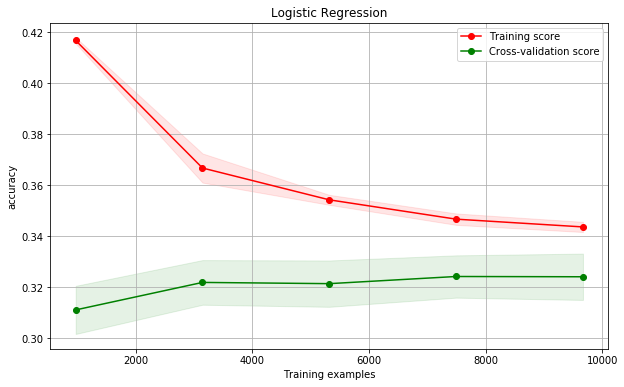

In [148]:
plot_learning_curve(model,'Logistic Regression', X_train, y_train, cv=10)

After using the optimal model generated from step 5 Model tuning, we apply the model to the testing dataset which we split at the begining of step 4. The test set accuracy is 70.82% while the training set accuracy is 71.25%. The training set accuracy is slightly higher. In order to increase the accuracy, we can try to include more features(currently 50). Additionally, we can do more feature Scaling and/or Normalization. The training and validation accuracy seem to go in parallel. Therefore, it is not overfitting. The model might be underfitting,so we might try to increase the complexity of the model.